*Ce billet a été écrit à l'aide d'un notebook Jupyter. Son contenu est sous licence BSD. Une vue statique de ce notebook peut être consultée et téléchargée ici : [20170614_Legislatives.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170614_Legislatives.ipynb).*

Dans ce billet, nous allons nous intéresser aux résultats du premier tour des législatives 2017. Ce billet fait suite à mes billets précédents sur les élections présidentielles ([premier tour](http://flothesof.github.io/cartes-premier-tour-presidentielle-2017.html), [deuxième tour](http://flothesof.github.io/cartes-second-tour-presidentielle-2017.html)) et utilise les mêmes techniques pour aspirer le site du ministère de l'intérieur, disponibles ici : <http://elections.interieur.gouv.fr/legislatives-2017>.

Une fois les données obtenues, nous essaierons de tracer des courbes intéressantes pour analyser les résultats. En fin de billet, nous proposerons un modèle probabiliste pour donner des bornes sur les résultats à attendre à l'issue du deuxième tour des législatives le 18 juin 2017.

# Téléchargement des données depuis le site du ministère de l'intérieur

In [1]:
# import des packages 
from bs4 import BeautifulSoup
import requests
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
from collections import OrderedDict
from scipy import stats
import numpy as np

Tout d'abord, allons aspirer le site officiel du ministère de l'intérieur.

In [2]:
url = 'http://elections.interieur.gouv.fr/legislatives-2017/'

In [3]:
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

Les résultats sont organisés par circonscription. Trouvons les liens vers toutes les pages relatives aux circonscriptions. En explorant le code source HTML de la page, j'ai abouti à l'extraction ci-dessous :

In [4]:
links = [url + tag.attrs['href'][2:] for tag in soup.find_all('a', class_='Style6')]

J'introduis une fonction qui garde en mémoire les pages téléchargées depuis le site du ministère avec un cache afin d'accélérer les extractions qui suivront.

In [5]:
from functools import lru_cache

@lru_cache(maxsize=None)
def fetch_page(url):
    "Fetches url for webpage."
    r = requests.get(url)
    return r

In [6]:
circo_links = []
for link in links:
    soup = BeautifulSoup(fetch_page(link).text, 'html.parser')
    circo_links += [url + tag.attrs['href'][3:] for tag in soup.find_all('a') if 'circonscription' in tag.text.lower()]

On vérifie qu'on a le bon nombre de circonscriptions, qui devrait être égal au 577 (nombre de députés à l'assemblée nationale).

In [7]:
len(circo_links)

577

Maintenant, nous allons pouvoir extraire les tableaux qui figurent sur les différentes pages.

In [8]:
r = fetch_page(circo_links[0])

In [9]:
soup = BeautifulSoup(r.text, 'html.parser')

On peut trouver le titre de la circonscription assez facilement :

In [10]:
soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]

'Ain (01) - 1ère'

On peut récuperer une première table sur les stats liés à la circonscription.

In [11]:
table = soup.find_all('tbody')[1]
votes = OrderedDict()
for row in table.find_all('tr'):
    votes[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))

In [12]:
pd.Series(votes).to_frame()

0
Inscrits     82694
Abstentions  42063
Votants      40631
Blancs         545
Nuls           155
Exprimés     39931

Ainsi que les résultats par candidat.

In [13]:
table = soup.find_all('tbody')[0]
candidates = OrderedDict()
for row in table.find_all('tr'):
    candidates[row.td.text] = []
    for td in row.find_all('td')[1:]:
        stripped = td.text.strip().replace(',', '.').replace(' ', '')
        candidates[row.td.text].append(stripped)

In [14]:
pd.DataFrame(candidates).transpose()

0      1      2      3           4
M. Laurent MALLET            MDM  13534  16.37  33.89  Ballotage*
M. Xavier BRETON              LR  10693  12.93  26.78  Ballotage*
M. Jérôme BUISSON             FN   6174   7.47  15.46         Non
Mme Fabrine MARTIN ZEMLIK     FI   3874   4.68   9.70         Non
Mme Florence BLATRIX-CONTAT  SOC   3687   4.46   9.23         Non
M. Jacques FONTAINE          COM    656   0.79   1.64         Non
Mme Laurane RAIMONDO         ECO    562   0.68   1.41         Non
Mme Maude LÉPAGNOT           EXG    293   0.35   0.73         Non
Mme Marie CARLIER            DIV    247   0.30   0.62         Non
M. Gilbert BONNOT            DIV    211   0.26   0.53         Non

On peut maintenant écrire une fonction qui rassemble ces extractions.

In [15]:
def extract_circo_data(url):
    "Returns data extracted from url: name of circonscription, candidates, votes."
    r = fetch_page(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    circo_name = soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]
    table = soup.find_all('tbody')[0]
    candidates = OrderedDict()
    for row in table.find_all('tr'):
        candidates[row.td.text] = []
        for td in row.find_all('td')[1:]:
            stripped = td.text.strip().replace(',', '.').replace(' ', '')
            candidates[row.td.text].append(stripped)
    table = soup.find_all('tbody')[1]
    votes = OrderedDict()
    for row in table.find_all('tr'):
        votes[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    votes = pd.Series(votes).to_frame()
    votes.columns = [circo_name]
    return circo_name, pd.DataFrame(candidates).transpose(), votes

Cette routine d'extraction permet d'obtenir, pour chaque circonscription, la table des résultats par candidat, le nom de la circonscription et les données statistiques sur les votants (inscrits, abstentions, votants, blancs, nuls, exprimés). Prenons un exemple avec la 2ème circonscription de la Haute-Marne. 

In [16]:
circo_name, candidates, votes = extract_circo_data(circo_links[245])

In [17]:
circo_name

'Haute-Marne (52) - 2ème'

In [18]:
votes

Haute-Marne (52) - 2ème
Inscrits                       61604
Abstentions                    32008
Votants                        29596
Blancs                           441
Nuls                             145
Exprimés                       29010

In [19]:
candidates

0     1      2      3           4
M. François CORNUT-GENTILLE   LR  9808  15.92  33.81  Ballotage*
M. Frédéric FABRE             FN  8431  13.69  29.06  Ballotage*
M. Vincent BERTHET           REM  6148   9.98  21.19         Non
M. Daniel MONNIER             FI  2380   3.86   8.20         Non
M. Antoine DESFRETIER        SOC   966   1.57   3.33         Non
Mme Valérie ROFFIDAL         ECO   466   0.76   1.61         Non
M. Edouard GONZALEZ          COM   414   0.67   1.43         Non
Mme Anne HALIN               EXG   214   0.35   0.74         Non
Mme Laurence OLIVIER         DIV   183   0.30   0.63         Non

Maintenant passons aux graphiques que nous allons pouvoir tracer à partir de ces données brutes par circonscription.

# Analyse des statistiques du vote par circonscription

Réunissons dans un premier temps tous les tableaux de données obtenus concernants les votes.

In [20]:
all_votes_data = [extract_circo_data(url)[2] for url in circo_links]

In [21]:
all_votes = pd.concat(all_votes_data, axis=1)

In [22]:
all_votes

Ain (01) - 1ère  Ain (01) - 2ème  Ain (01) - 3ème  \
Inscrits               82694            93520            75614   
Abstentions            42063            47291            41131   
Votants                40631            46229            34483   
Blancs                   545              471              359   
Nuls                     155              160              116   
Exprimés               39931            45598            34008   

             Ain (01) - 4ème  Ain (01) - 5ème  Aisne (02) - 1ère  \
Inscrits               89390            75359              72345   
Abstentions            45625            38409              36770   
Votants                43765            36950              35575   
Blancs                   521              374                517   
Nuls                     211              168                173   
Exprimés               43033            36408              34885   

             Aisne (02) - 2ème  Aisne (02) - 3ème  Aisne (02) - 4ème  \
Inscrits                 73981              68099              79116   
Abstentions              39857              35369              43878   
Votants                  34124              32730              35238   
Blancs                     685                639                530   
Nuls                       270                287                208   
Exprimés                 33169              31804              34500   

             Aisne (02) - 5ème                      ...                       \
Inscrits                 82223                      ...                        
Abstentions              41864                      ...                        
Votants                  40359                      ...                        
Blancs                     609                      ...                        
Nuls                       251                      ...                        
Exprimés                 39499                      ...                        

             Français établis hors de France (99) - 2ème  \
Inscrits                                           75029   
Abstentions                                        63414   
Votants                                            11615   
Blancs                                                36   
Nuls                                                  79   
Exprimés                                           11500   

             Français établis hors de France (99) - 3ème  \
Inscrits                                          120696   
Abstentions                                        95202   
Votants                                            25494   
Blancs                                                43   
Nuls                                                  81   
Exprimés                                           25370   

             Français établis hors de France (99) - 4ème  \
Inscrits                                          122765   
Abstentions                                        94943   
Votants                                            27822   
Blancs                                                68   
Nuls                                                  90   
Exprimés                                           27664   

             Français établis hors de France (99) - 5ème  \
Inscrits                                           91374   
Abstentions                                        76810   
Votants                                            14564   
Blancs                                                71   
Nuls                                                  48   
Exprimés                                           14445   

             Français établis hors de France (99) - 6ème  \
Inscrits                                          127486   
Abstentions                                       101742   
Votants                                            25744   
Blancs                                                47   
Nuls                   

Commençons par agréger les résultats en les sommant.

In [23]:
all_votes.sum(axis=1).to_frame(name='France entière')

France entière
Inscrits           47570988
Abstentions        24403480
Votants            23167508
Blancs               357018
Nuls                 156326
Exprimés           22654164

On peut représenter ceci sous forme d'un graphique.

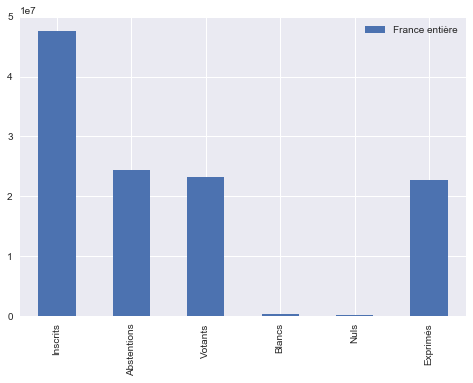

In [24]:
all_votes.sum(axis=1).to_frame(name='France entière').plot.bar()

Comme cela a été signalé dans la presse, il y a eu plus d'abstentions que de votants. On remarque qu'il y a beaucoup moins de blancs et de nuls que lors de la présidentielle (2,5 millions de blancs au deuxième tour de la présidentielle). 10 millions de Français de plus se sont abstenus d'aller voter qu'au deuxième tour de la présidentielle. 

Regardons maintenant quel graphique nous obtenons si nous faisons un graphique pour toutes les circonscriptions.

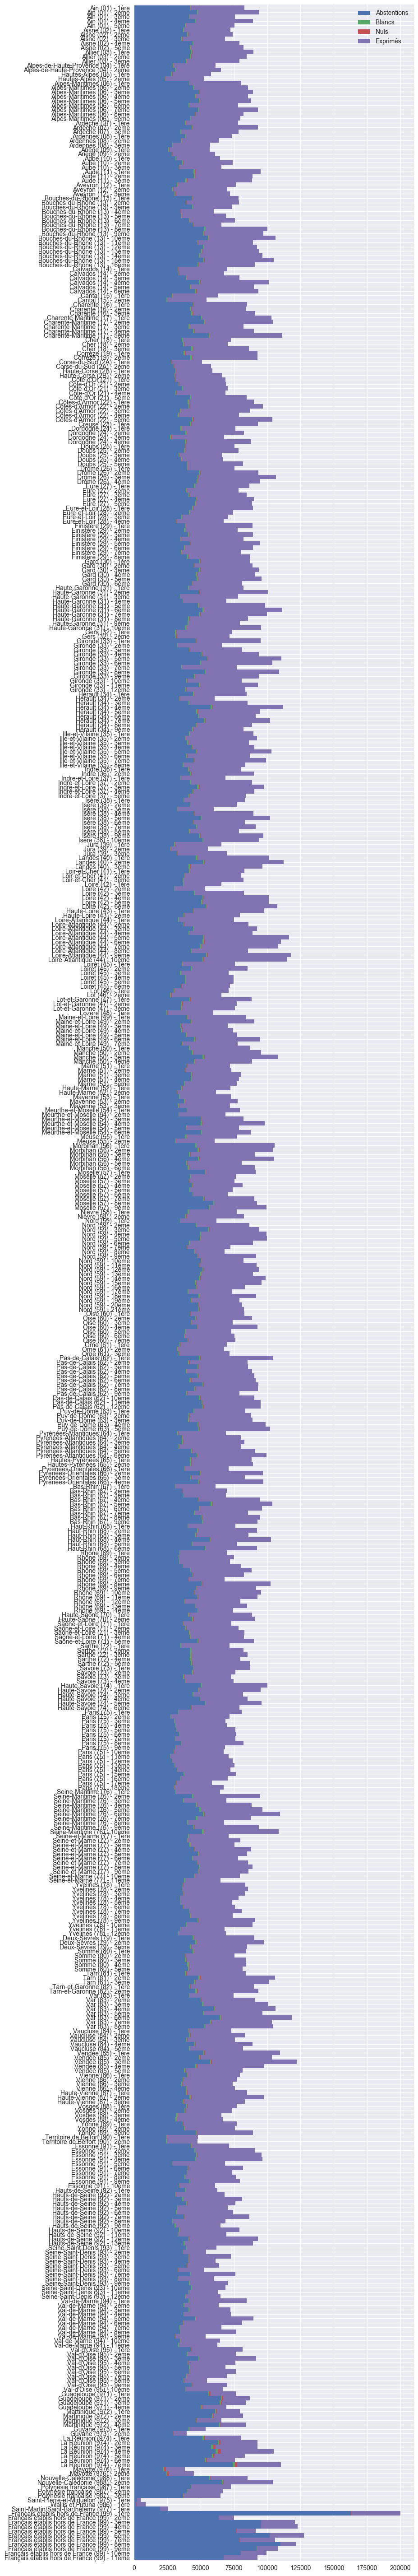

In [25]:
fig, ax = plt.subplots(figsize=(8, 75), dpi=100)
all_votes.transpose()[['Abstentions', 'Blancs', 'Nuls', 'Exprimés']].iloc[::-1].plot.barh(stacked=True, ax=ax, width=1.0)

On peut également reprendre le même graphique, mais en normalisant par rapport à la somme des inscrits.

In [26]:
all_votes_relative = all_votes.transpose().copy()
for col in all_votes_relative:
    all_votes_relative[col] = all_votes_relative[col] / all_votes.transpose()['Inscrits']

In [27]:
all_votes_relative

Inscrits  Abstentions   Votants  \
Ain (01) - 1ère                                    1.0     0.508658  0.491342   
Ain (01) - 2ème                                    1.0     0.505678  0.494322   
Ain (01) - 3ème                                    1.0     0.543960  0.456040   
Ain (01) - 4ème                                    1.0     0.510404  0.489596   
Ain (01) - 5ème                                    1.0     0.509680  0.490320   
Aisne (02) - 1ère                                  1.0     0.508259  0.491741   
Aisne (02) - 2ème                                  1.0     0.538746  0.461254   
Aisne (02) - 3ème                                  1.0     0.519376  0.480624   
Aisne (02) - 4ème                                  1.0     0.554603  0.445397   
Aisne (02) - 5ème                                  1.0     0.509152  0.490848   
Allier (03) - 1ère                                 1.0     0.475640  0.524360   
Allier (03) - 2ème                                 1.0     0.493498  0.506502   
Allier (03) - 3ème                                 1.0     0.490003  0.509997   
Alpes-de-Haute-Provence (04) - 1ère                1.0     0.474919  0.525081   
Alpes-de-Haute-Provence (04) - 2ème                1.0     0.468405  0.531595   
Hautes-Alpes (05) - 1ère                           1.0     0.484582  0.515418   
Hautes-Alpes (05) - 2ème                           1.0     0.445456  0.554544   
Alpes-Maritimes (06) - 1ère                        1.0     0.509892  0.490108   
Alpes-Maritimes (06) - 2ème                        1.0     0.515099  0.484901   
Alpes-Maritimes (06) - 3ème                        1.0     0.544768  0.455232   
Alpes-Maritimes (06) - 4ème                        1.0     0.533855  0.466145   
Alpes-Maritimes (06) - 5ème                        1.0     0.551346  0.448654   
Alpes-Maritimes (06) - 6ème                        1.0     0.523864  0.476136   
Alpes-Maritimes (06) - 7ème                        1.0     0.514676  0.485324   
Alpes-Maritimes (06) - 8ème                        1.0     0.554208  0.445792   
Alpes-Maritimes (06) - 9ème                        1.0     0.526472  0.473528   
Ardèche (07) - 1ère                                1.0     0.486994  0.513006   
Ardèche (07) - 2ème                                1.0     0.464164  0.535836   
Ardèche (07) - 3ème                                1.0     0.442153  0.557847   
Ardennes (08) - 1ère                               1.0     0.521263  0.478737   
...                                                ...          ...       ...   
Guyane (973) - 1ère                                1.0     0.761466  0.238534   
Guyane (973) - 2ème                                1.0     0.739048  0.260952   
La Réunion (974) - 1ère                            1.0     0.639062  0.360938   
La Réunion (974) - 2ème                            1.0     0.678201  0.321799   
La Réunion (974) - 3ème                            1.0     0.621123  0.378877   
La Réunion (974) - 4ème                            1.0     0.582800  0.417200   
La Réunion (974) - 5ème                            1.0     0.701249  0.298751   
La Réunion (974) - 6ème                            1.0     0.696498  0.303502   
La Réunion (974) - 7ème                            1.0     0.670173  0.329827   
Mayotte (976) - 1ère                               1.0     0.577151  0.422849   
Mayotte (976) - 2ème                               1.0     0.539025  0.460975   
Nouvelle-Calédonie (988) - 1ère                    1.0     0.660650  0.339350   
Nouvelle-Calédonie (988) - 2ème                    1.0     0.628350  0.371650   
Polynésie française (987) - 1ère                   1.0     0.582930  0.417070   
Polynésie française (987) - 2ème                   1.0     0.589746  0.410254   
Polynésie française (987) - 3ème                   1.0     0.564492  0.435508   
Saint-Pierre-et-Miquelon (975) - 1ère              1.0     0.405509  0.594491   
Wallis et Futuna (986) - 1ère                      1.0     0.187264  0.812736

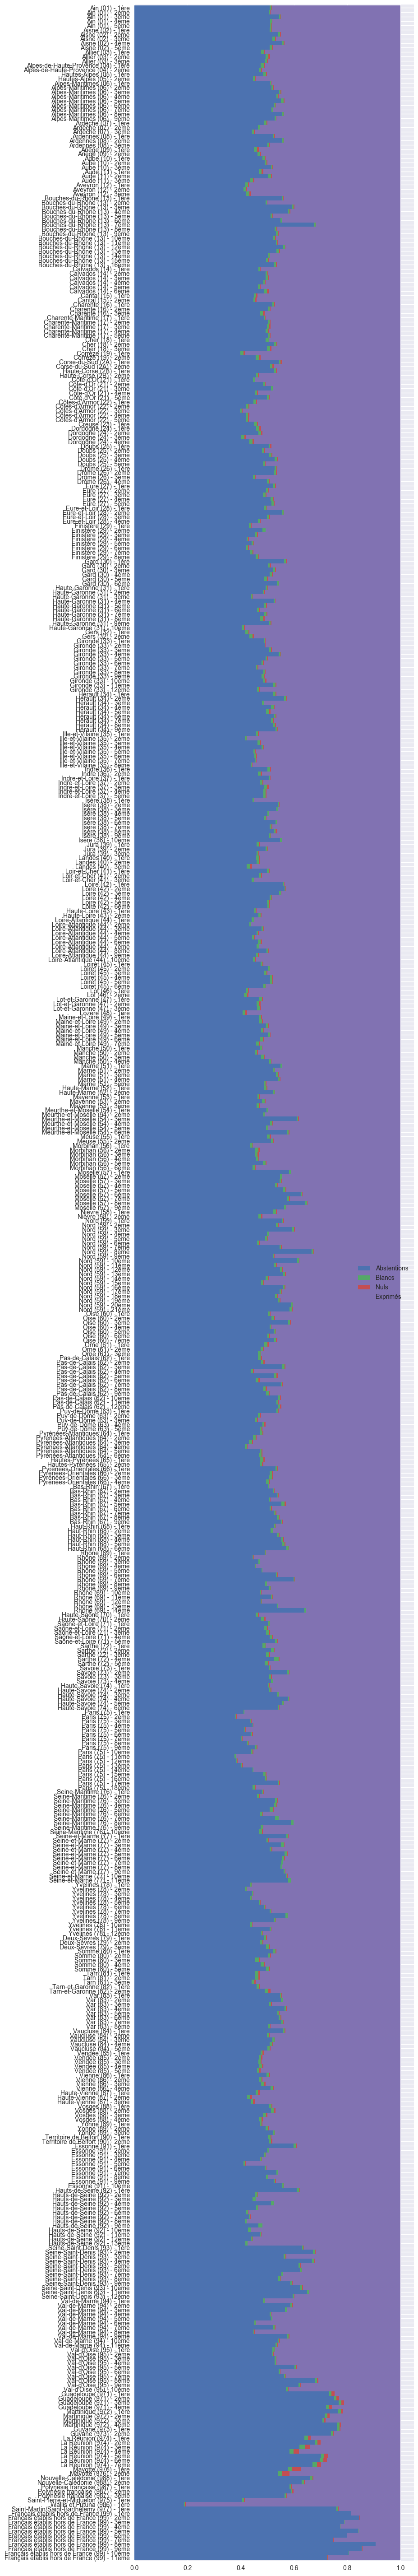

In [28]:
fig, ax = plt.subplots(figsize=(8, 75), dpi=100)
all_votes_relative[['Abstentions', 'Blancs', 'Nuls', 'Exprimés']].iloc[::-1].plot.barh(stacked=True, ax=ax, width=1.0)

Une autre manière de représenter ces données peut être l'utilisation d'un scatter plot. Nous allons faire ceci avec `seaborn`. La fonction `pairplot` nous permet de dessiner les corrélations entre les variables deux à deux. Voyons-voir si certaines de ces corrélations attirent notre attention. 

In [29]:
import seaborn as sns

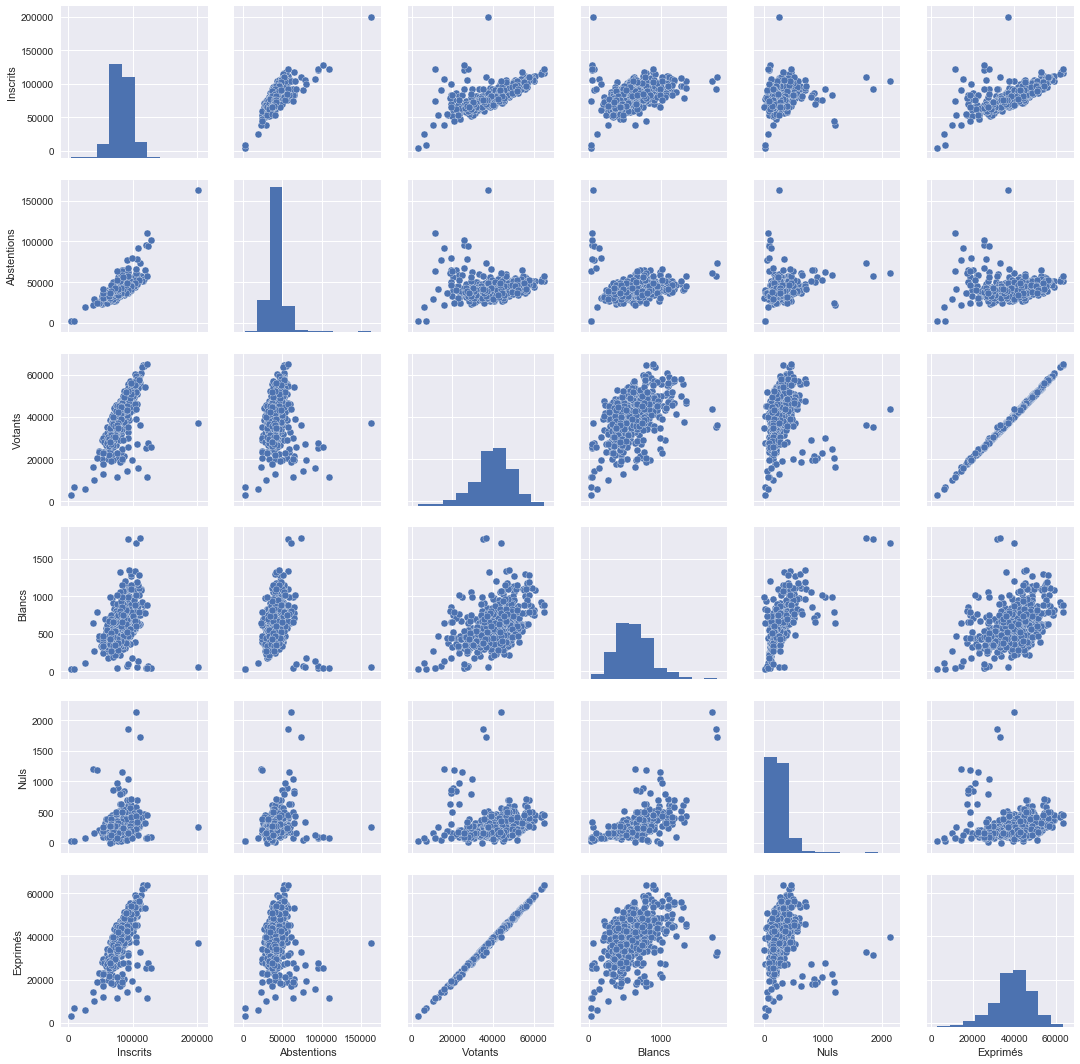

In [30]:
sns.pairplot(all_votes.transpose())

Ce qui ressort de ces diagrammes, c'est qu'il y semble toujours y avoir une relation de proportionnalité entre fondamentalement les inscrits et toutes les autres variables. Plus il y a d'inscrits, plus il y a de votants, de blancs, d'abstentions... etc.

# Par candidat 

Passons maintenant à l'exploitation des autres données que nous avons obtenues et analysons les avec une approche par candidat. 

In [31]:
all_candidates_data = []
for url in circo_links:
    circo_name, candidates, votes = extract_circo_data(url)
    candidates.columns = ['Nuances', 'Voix', '% Inscrits', '% Exprimés', 'Ballotage']
    for col in ['Voix', '% Inscrits', '% Exprimés']:
        candidates[col] = pd.to_numeric(candidates[col])
    candidates['Circonscription'] = circo_name
    all_candidates_data.append(candidates)

In [32]:
all_candidates = pd.concat(all_candidates_data)

Les règles qui gouvernent le scrutin sont les suivantes ([source](https://www.service-public.fr/particuliers/vosdroits/F1943)): 

> Pour être élu au 1er tour, un candidat doit recueillir :

> - plus de 50 % des suffrages exprimés,

> - et un nombre de voix au moins égal à 25 % des électeurs inscrits.

> Si aucun candidat n'est élu dès le premier tour, il est procédé à un 2nd tour une semaine plus tard.

> Au 2nd tour, les 2 candidats arrivés en tête peuvent se maintenir.

> Les candidats suivants peuvent se maintenir seulement s'ils ont obtenu un nombre de suffrages au moins égal à 12,5 % des électeurs inscrits.

> Le candidat qui obtient le plus grand nombre de suffrages au 2nd tour est élu.

Au premier tour, les candidats élus d'office étaient les suivants :

In [33]:
all_candidates[all_candidates.Ballotage == 'Oui']

Nuances   Voix  % Inscrits  % Exprimés Ballotage  \
M. Paul MOLAC           REM  30166       28.70       54.00       Oui   
M. Sylvain MAILLARD     REM  24037       29.76       50.80       Oui   
M. Stéphane DEMILLY     UDI  21505       26.40       53.85       Oui   
M. Napole POLUTELE      DVG   3436       40.52       50.24       Oui   

                                   Circonscription  
M. Paul MOLAC                 Morbihan (56) - 4ème  
M. Sylvain MAILLARD              Paris (75) - 1ère  
M. Stéphane DEMILLY              Somme (80) - 5ème  
M. Napole POLUTELE   Wallis et Futuna (986) - 1ère

On peut aggréger les données par nombre de voix :

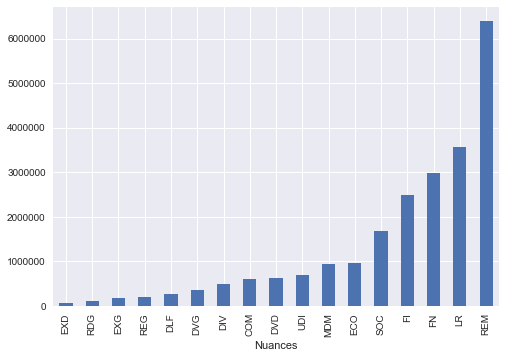

In [34]:
all_candidates.groupby('Nuances').sum()['Voix'].sort_values().plot.bar()

On constate que le grand gagnant de cette élection est la République en Marche. Derrière, on trouve les Républicains, le FN, la France Insoumise et le PS.

On peut regarder combien de candidats sont en ballotage par nuance politique.

In [35]:
all_candidates[all_candidates.Ballotage == 'Ballotage*']['Nuances'].value_counts()

REM    454
LR     265
FN     120
FI      67
SOC     65
MDM     62
UDI     35
DVD     22
DVG     18
COM     12
REG      9
DIV      9
RDG      5
ECO      2
EXD      1
DLF      1
Name: Nuances, dtype: int64

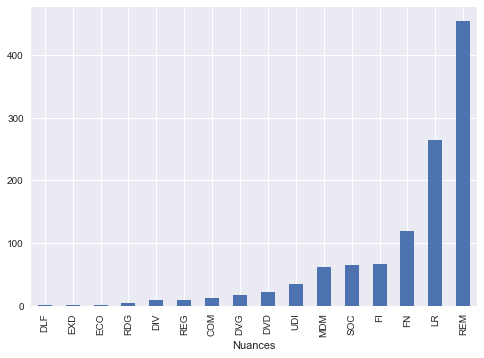

In [36]:
all_candidates[all_candidates.Ballotage == 'Ballotage*'].groupby('Nuances').count()['Voix'].sort_values().plot.bar()

Le graphique ci-dessus représente ainsi le nombre maximum de députés possibles selon leur nuance politique.

On retrouve la tendance observée précédemment en nombre de voix, mais avec un effet lié au mode de scrutin. 

On peut s'en rendre compte en traçant une droite proportionnelle au nombre de votants et de pente le nombre de députés total (577) divisé par le nombre de votants total.

In [37]:
max_mps = all_candidates[all_candidates.Ballotage == 'Ballotage*'].groupby('Nuances').count()['Voix']
by_voice = all_candidates.groupby('Nuances').sum()['Voix']

In [38]:
mp_voice = pd.DataFrame([max_mps, by_voice]).transpose()
mp_voice.columns = ['Députés max.', 'Voix']
mp_voice = mp_voice.fillna(value=0)

(-10, 500)

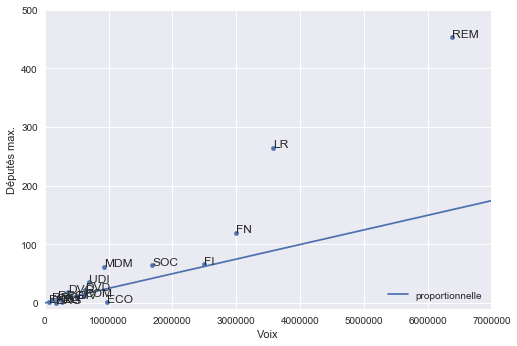

In [39]:
mp_voice.plot.scatter(x='Voix', y='Députés max.')
for label, data in mp_voice.iterrows():
    plt.annotate(xy=(data['Voix'], data['Députés max.']), s=label)
plt.plot([0, all_votes.transpose().sum()['Votants']], [0, 577], label='proportionnelle')
plt.legend(loc='lower right')
plt.xlim(0, 7e6)
plt.ylim(-10, 500)

Dans le graphique ci-dessus, la droite représente le nombre de sièges attendu si les élections étaient décidées à la proportionnelle. 
On remarque que la droite "proportionnelle" est parfois bien loin au-dessus ou au-dessous du nombre de siège maximum. 

La République en marche peut par exemple finir avec près de 500 députés alors que la proportionnalité au nombre de votants impliquerait seulement 200 députés. 

A l'inverse, la France Insoumise peut devenir au mieux représentative de son vote proportionnel et cela seulement si elle gagne dans toutes les circonscriptions où elle se trouve en ballotage (environ 70 circonscriptions).

Le graphique ci-dessus ne donne que le nombre de siège maximum. Qu'en est-il du minimum par parti ? De la moyenne ? Pour aller plus loin, nous pouvons proposer un modèle statistique assez simple dans la prochaine partie.

# Modèle probabiliste pour les résultats du second tour des législatives

Le graphe précédent est intéressant, mais malheureusement, il ne permet pas de juger de manière de ce qui peut se passer au second tour, dans la mesure où nous ne dessinons que le nombre maximum de députés par nuance politique, mais pas sa distribution. Pour obtenir une approximation de cette distribution, nous pouvons proposer un modèle probabiliste très simple : pour chaque circonscription, nous tirons au hasard l'un des députés en ballotage, avec le pourcentage calculé à partir de ses votes du premier tour, c'est-à-dire que l'on suppose que les reports se font de manière équilibrée vis-à-vis des candidats en ballotage au premier tour.

Prenons un exemple. Dans la première circonscription de l'Ain, nous avons les candidats suivants pour le ballotage.

In [40]:
all_candidates[(all_candidates.Circonscription == 'Ain (01) - 1ère') & (all_candidates.Ballotage == 'Ballotage*')]

Nuances   Voix  % Inscrits  % Exprimés   Ballotage  \
M. Laurent MALLET     MDM  13534       16.37       33.89  Ballotage*   
M. Xavier BRETON       LR  10693       12.93       26.78  Ballotage*   

                   Circonscription  
M. Laurent MALLET  Ain (01) - 1ère  
M. Xavier BRETON   Ain (01) - 1ère

Le candidat Modem a reçu 13534 voix, tandis que le candidat LR a reçu 10693 voix. On voit que les candidats sont à peu près à égalité. On peut donc faire des tirages dont la probabilité est proportionnelle à ce nombre de voix.

Le tirage se fait donc sur la base de ce nombre de voix normalisé. On peut construire une variable aléatoire avec [Scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.rv_discrete.html) sur ce principe.

In [41]:
voices = [13534, 10693]

In [42]:
xk = np.arange(len(voices))
pk = np.array(voices) / np.sum(voices)
custm = stats.rv_discrete(name='custm', values=(xk, pk))

On peut avec cet objet, faire des tirages. Si on fait autant de tirages que de voix exprimées pour ces deux candidats initialement, on peut vérifier que le tirage fonctionne bien car on s'attend à retrouver un chiffre proche du nombre de voix écrit reporté ci-avant.

In [43]:
pd.Series(custm.rvs(size=(13534 + 10693))).value_counts()

0    13604
1    10623
dtype: int64

Nous pouvons maintenant écrire une fonction qui simule un vainqueur par circonscription, avec en option de le faire un certain nombre de fois pour donner une vision statistique de la distribution.

In [44]:
def predict_winner(circo_name, size=1):
    "Simulates who will win a given circonscription."
    df_circo = all_candidates[all_candidates.Circonscription == circo_name]
    if 'Oui' in df_circo['Ballotage'].any():
        return np.array([v for v in df_circo.Nuances[df_circo.Ballotage == 'Oui'].values] * size)
    else:
        mask = df_circo.Ballotage == 'Ballotage*'
        voices = df_circo.Voix[mask].values
        nuances = df_circo.Nuances[mask].values
        xk = np.arange(voices.size)
        pk = np.array(voices) / np.sum(voices)
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        return nuances[custm.rvs(size=size)]

On peut vérifier que la simulation fonctionne :

In [45]:
predict_winner(circo_name, size=100)

array(['REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'LR', 'REM', 'LR', 'LR',
       'REM', 'LR', 'LR', 'REM', 'REM', 'REM', 'REM', 'LR', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'LR', 'REM', 'REM', 'REM',
       'REM', 'LR', 'REM', 'LR', 'REM', 'REM', 'LR', 'REM', 'REM', 'REM',
       'LR', 'LR', 'LR', 'REM', 'LR', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'LR', 'LR', 'LR', 'LR', 'REM', 'REM',
       'LR', 'REM', 'REM', 'LR'], dtype=object)

Ainsi que dans une circonscription où le premier tour a déjà déterminé le gagnant (pour vérifier qu'on retrouve toujours le même gagnant) :

In [46]:
predict_winner('Morbihan (56) - 4ème', size=100)

array(['REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM'], 
      dtype='<U3')

On peut maintenant, à partir de la liste des circonscriptions, faire des simulations des miliers de simulations, afin d'avoir des statistiques sur la composition possible de l'assemblée.

In [47]:
simulation_data = [predict_winner(circo_name, 10000) for circo_name in all_candidates.Circonscription.unique()]

In [48]:
parliaments = pd.DataFrame(simulation_data, index=all_candidates.Circonscription.unique()).transpose()

On va aggréger ces simulations en comptant le nombre de députés par parti politique.

In [49]:
parliament_counts = pd.concat([series.value_counts() for ind, series in parliaments.iterrows()], axis=1).fillna(value=0)

On peut trier ces données par nombre de députés et faire la moyenne des simulations que nous avons faites.

In [50]:
parliament_counts.transpose().describe().transpose().sort_values(by='mean')[['min', '25%', '50%', '75%', 'max']].transpose().astype(int)

EXD  DLF  ECO  RDG  DIV  REG  COM  DVD  DVG  UDI  FI  SOC  MDM  FN   LR  \
min    0    0    0    0    0    0    0    3    4    5   7   12   24  31   81   
25%    0    0    1    1    3    3    4    8    9   14  19   24   35  47  103   
50%    0    0    1    2    4    4    6    9   10   16  22   26   38  50  109   
75%    1    1    1    3    5    5    7   11   11   18  25   29   40  54  114   
max    1    1    2    5    9    9   11   18   16   28  38   42   52  72  138   

     REM  
min  242  
25%  272  
50%  279  
75%  286  
max  313

Comme on peut le voir, on s'attend à entre 243 et 315 députés En Marche, 79 à 140 députés LR, 31 à 71 députés FN, 22 à 51 députés Modem, 12 et 39 députés PS, 9 à 37 députés France Insoumise.

Ces résultats ne tiennent pas compte du fait que des alliances éventuelles vont en fait changer la manière dont se feront les reports de vote. Typiquement, on peut envisager des stratégies comme le barrage au FN, qui va donc tendre à accentuer le report des votes vers les autres candidats et les alliances entre France Insoumise et le Parti Communiste, qui peut renforcer la représentation de ces partis.

Sans rentrer dans ces subtilités, on peut s'en tenir aux estimations précédentes, que l'on peut représenter graphiquement avec des barres d'erreur.

/Users/kappamaki/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


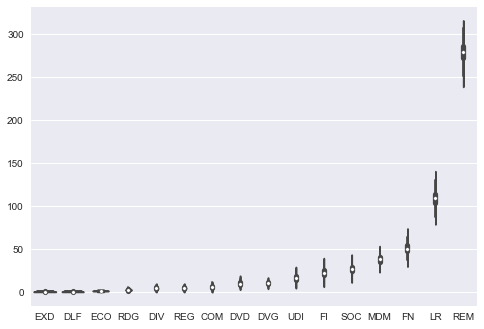

In [51]:
sorted_columns = parliament_counts.transpose().describe().transpose().sort_values(by='mean').index.values
sns.violinplot(parliament_counts.transpose()[sorted_columns])

S'il ne fallait retenir qu'un chiffre des prédictions du modèle probabiliste, ce serait celui du nombre médian de siège par nuance politique :

In [52]:
parliament_counts.transpose().describe().transpose().sort_values(by='mean')[['50%']].transpose().astype(int)

EXD  DLF  ECO  RDG  DIV  REG  COM  DVD  DVG  UDI  FI  SOC  MDM  FN   LR  \
50%    0    0    1    2    4    4    6    9   10   16  22   26   38  50  109   

     REM  
50%  279

On peut donc reprendre le graphique précédent avec les score attendus en proportion des voix reçues au premier tour et comparer ceci au score attendu d'après les simulations. 

In [53]:
proportion_seats = all_candidates.groupby('Nuances').sum()['Voix'] / all_votes.transpose().sum()['Votants'] * 577

/Users/kappamaki/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


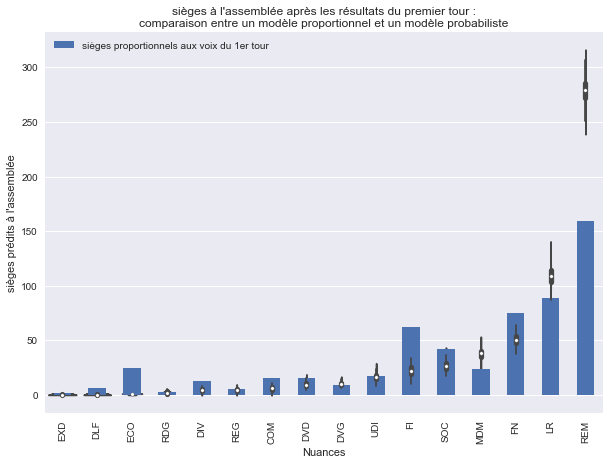

In [54]:
fig, ax = plt.subplots(figsize=(10, 7))
proportion_seats[sorted_columns].to_frame(name='sièges proportionnels aux voix du 1er tour').plot.bar(ax=ax)
sns.violinplot(parliament_counts.transpose()[sorted_columns], label='modèle probabiliste', ax=ax)
plt.ylabel("sièges prédits à l'assemblée")
plt.legend(loc='upper left')
plt.title("sièges à l'assemblée après les résultats du premier tour :\ncomparaison entre un modèle proportionnel et un modèle probabiliste");

Le graphique ci-dessus permet de conclure quant à la question initiale avec des données quantitatives : il semble que les conditions du scrutin favorisent grandement la République en Marche dans la mesure où en proportion des voix exprimées, le nombre de députés REM devrait être seulement la moitié de ce que le modèle probabiliste propose. De même, les autres gagnants sont LR et le Modem, alors que les perdants sont le FN, les socialistes, la France Insoumise, et les écologistes dont le nombre de siège tend vers zéro (car en ballotage dans seulement deux circonscriptions) alors qu'une fraction importantes des votants s'est déclaré en sa faveur.  

# Conclusions 

Dans ce billet, nous sommes partis des pages officielles du ministère de l'intérieur. Nous avons extrait les données pour les 577 circonscriptions, les avons représentés et étudiés l'effet des règles du scrutin sur la répartition des sièges au travers d'un modèle probabiliste. 

Ceci nous a permis de mettre en évidence quels partis peuvent être considérés comme les vainqueurs ou les perdants de ce premier tour des législatives. Le modèle probabiliste permet de prédire que le raz-de-marée de la République en Marche devrait lui permettre d'atteindre une majorité absolue, à quelques sièges près, en décalage avec la proportion de votants en faveur du parti, nettement inférieur. Ce déséquilibre est dû au mode de scrutin, qui favorise en ballotage les partis avec des scores importants au premier tour. Ces résultats sont assez étonnants, notamment du fait que plus de la moitié des inscrit n'a pas voté lors de ces élections.